## Perform Analysis on Athletes

This file reads the detailed athlete information and performs Linear Regression analysis on this data.   

The following areas are examined in this code

* <a href=#Visualize>Visualize Data</a>   

* <a href=#LinearRegression>Linear Regression</a>   

* <a href=#LASSO>LASSO</a>   

* <a href=#MixedEffect>Mixed Effect</a>

* <a href=#Algebraic>Algebraic Model</a>


In [2]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

%matplotlib inline

## Read data 

In [3]:
boy1600  = pd.read_csv("../1allDistrict_boy1600.csv")
girl1600 = pd.read_csv("../1allDistrict_girl1600.csv")
girl400  = pd.read_csv("../1allDistrict_girl400.csv")
boy400   = pd.read_csv("../1allDistrict_boy400.csv")

boy1600['sex']  = 'boy'
girl1600['sex'] = 'girl'
boy400['sex']  = 'boy'
girl400['sex'] = 'girl'

print(f"Girl 1600: {girl1600.shape}")
print(f"Boy  1600: {boy1600.shape}")
print(f"Girl 400:  {girl400.shape}")
print(f"Boy  400:  {boy400.shape}")

Girl 1600: (852, 12)
Boy  1600: (1204, 12)
Girl 400:  (382, 12)
Boy  400:  (444, 12)


In [5]:
# put the boy and girl data into one file
athlete_data = pd.concat([boy1600,girl1600])
#athlete_data = pd.concat([boy400,girl400])

print(athlete_data.shape)
print(athlete_data.columns)

(2056, 12)
Index(['Unnamed: 0', 'ID', 'Name', 'School_ID', 'School', 'District', '9_PR',
       '10_PR', '11_PR', '12_PR', 'Grad_Yr', 'sex'],
      dtype='object')


In [6]:
# rename columns because statsmodels doesn't like the 12_PR format
# add a numerical column for sex of the athlete
athlete_data['PR12'] = athlete_data['12_PR']
athlete_data['PR11'] = athlete_data['11_PR']
athlete_data['PR10'] = athlete_data['10_PR']
athlete_data['PR9']  = athlete_data['9_PR']

athlete_data['Nsex'] = [1 if s == 'boy' else 0 for s in athlete_data['sex']]

In [7]:
print('number of unique schools: ',len(athlete_data['School'].unique()))

number of unique schools:  200


## Set up X and y

In [8]:
# How many unique athletes in each district
athlete_data.District.value_counts()

District 3    615
District 1    488
District 2    317
District 4    279
District 5    235
District 6    119
District 8      2
District 7      1
Name: District, dtype: int64

In [9]:
print(athlete_data.District[athlete_data.District == 'District 7'])
print(athlete_data.District[athlete_data.District == 'District 8'])

104    District 7
Name: District, dtype: object
201    District 8
252    District 8
Name: District, dtype: object


In [10]:
# for 1600 data

# drop the 3 athletes from District 7 and 8
athlete_data.drop(index=104,inplace=True)
athlete_data.drop(index=201,inplace=True)
athlete_data.drop(index=252,inplace=True)

In [11]:
print(athlete_data.District[athlete_data.District == 'District 7'])
print(athlete_data.District[athlete_data.District == 'District 8'])

Series([], Name: District, dtype: object)
Series([], Name: District, dtype: object)


In [12]:
# for 400 data

# drop the athlete from District 8
athlete_data.drop(index=132,inplace=True)


In [13]:
athlete_data.head()

,Unnamed: 0,ID,Name,School_ID,School,District,9_PR,10_PR,11_PR,12_PR,Grad_Yr,sex,PR12,PR11,PR10,PR9,Nsex
0,0,290897,Tyler King,298,Coupeville,District 3,271.44,264.50,255.28,252.97,2011,boy,252.97,255.28,264.50,271.44,1
1,1,239023,Bereket Piatt,358,Port Townsend,District 3,276.00,265.58,268.16,265.20,2011,boy,265.20,268.16,265.58,276.00,1
2,2,262221,Ethan Tonnemaker,330,Royal,District 5,293.90,278.42,281.35,275.15,2011,boy,275.15,281.35,278.42,293.90,1
3,3,536508,Hap Emmons,345,King's,District 1,283.22,264.46,261.56,257.71,2012,boy,257.71,261.56,264.46,283.22,1
4,4,330570,Michael Milbank,301,Bellevue Christian,District 3,302.14,284.32,284.20,289.45,2011,boy,289.45,284.20,284.32,302.14,1


Variable  |Description                    |Value
----------|------------------------------:|:----
District 1|Athlete school in this district| 0 or 1
District 2|Athlete school in this district| 0 or 1
District 3|Athlete school in this district| 0 or 1
District 4|Athlete school in this district| 0 or 1
District 5|Athlete school in this district| 0 or 1
District 6|Athlete school in this district| 0 or 1
Sex       |Athlete girl or boy            | 1=boy, 0=girl
Grad Year |Graduation Year                | int
9th Grade PR|Best time in 9th Grade       | float
10th Grade PR|Best time in 10th Grade     | float
11th Grade PR|Best time in 11th Grade     | float|  

In [14]:
#given the athlete_data read from files, generate the X & y dataframes
def get_Xy(athlete_data,Dist=100):
    X = pd.DataFrame()

    if Dist == 100:
        # create one-hot columns for District
        X = pd.get_dummies(athlete_data[['District']])

        X = pd.concat([X, athlete_data[['PR9','PR10','PR11','Nsex','Grad_Yr']]], axis=1, sort=False)
        y = athlete_data['PR12']

    else:
        filtered_data = athlete_data[athlete_data['District'] == 'District '+str(Dist)]
        X = filtered_data[['PR9','PR10','PR11','Nsex','Grad_Yr']]
        y = filtered_data['PR12']
        #y = pd.DataFrame(y.values.reshape((len(y),1)))
    
    return(X,y)

X,y = get_Xy(athlete_data,100)

In [15]:
X.shape

(2048, 11)

In [16]:
y.shape

(2048,)

In [17]:
type(y)

pandas.core.series.Series

## Visualize Data <a name='Visualize' />

In [157]:
X.corr()

,District_District 1,District_District 2,District_District 3,District_District 4,District_District 5,District_District 6,PR9,PR10,PR11,Nsex,Grad_Yr
District_District 1,1.000000,-0.236095,-0.339723,-0.221706,-0.208052,-0.148601,-0.022541,-0.014735,-0.026302,0.019415,-0.030897
District_District 2,-0.236095,1.000000,-0.266931,-0.174201,-0.163473,-0.116761,-0.008534,-0.043008,-0.031126,0.007756,0.051186
District_District 3,-0.339723,-0.266931,1.000000,-0.250663,-0.235226,-0.168010,0.036837,-0.003232,0.025307,-0.016991,0.019866
District_District 4,-0.221706,-0.174201,-0.250663,1.000000,-0.153510,-0.109645,-0.011428,0.026443,0.004446,-0.013108,-0.004197
District_District 5,-0.208052,-0.163473,-0.235226,-0.153510,1.000000,-0.102892,0.013436,0.025052,0.023472,0.011800,-0.011728
District_District 6,-0.148601,-0.116761,-0.168010,-0.109645,-0.102892,1.000000,-0.017338,0.022890,0.006854,-0.010897,-0.036109
PR9,-0.022541,-0.008534,0.036837,-0.011428,0.013436,-0.017338,1.000000,0.865282,0.837591,-0.627950,0.090505
PR10,-0.014735,-0.043008,-0.003232,0.026443,0.025052,0.022890,0.865282,1.000000,0.919099,-0.730165,0.085912
PR11,-0.026302,-0.031126,0.025307,0.004446,0.023472,0.006854,0.837591,0.919099,1.000000,-0.757540,0.047910
Nsex,0.019415,0.007756,-0.016991,-0.013108,0.011800,-0.010897,-0.627950,-0.730165,-0.757540,1.000000,-0.002285


In [158]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 0 to 381
Data columns (total 11 columns):
District_District 1    818 non-null uint8
District_District 2    818 non-null uint8
District_District 3    818 non-null uint8
District_District 4    818 non-null uint8
District_District 5    818 non-null uint8
District_District 6    818 non-null uint8
PR9                    818 non-null float64
PR10                   818 non-null float64
PR11                   818 non-null float64
Nsex                   818 non-null int64
Grad_Yr                818 non-null int64
dtypes: float64(3), int64(2), uint8(6)
memory usage: 43.1 KB


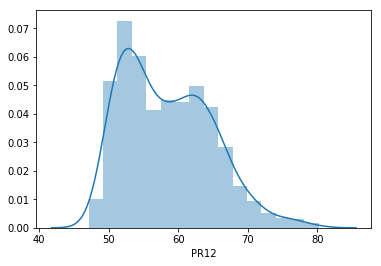

In [159]:
sns.distplot(athlete_data['PR12'])
plt.show()

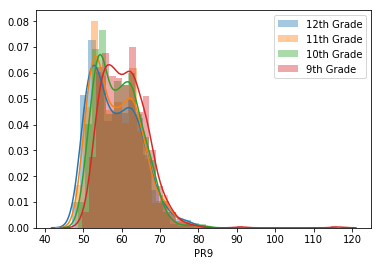

In [165]:
sns.distplot(athlete_data['PR12'],label = '12th Grade',norm_hist=False)
sns.distplot(athlete_data['PR11'],label = '11th Grade',norm_hist=False)
sns.distplot(athlete_data['PR10'],label = '10th Grade',norm_hist=False)
sns.distplot(athlete_data['PR9'],label = '9th Grade',norm_hist=False)
plt.legend()
plt.show();

In [ ]:
# plot 9th grade PR vs 12th grade PR for boys by district
grid=sns.lmplot(x = "PR9",y = "PR12",col="District",
                col_wrap=3, 
                data=athlete_data[athlete_data['Nsex'] == 1])
plt.ylim(top=450)     # adjust the top leaving bottom unchanged
plt.ylim(bottom=240)  # adjust the top leaving bottom unchanged

In [ ]:
sns.catplot(x="District",y="PR12", 
            data=athlete_data[(athlete_data['Nsex'] == 1)]);
#plt.figure(figsize=(10,2))
plt.ylabel('12th grade PR (Seconds)')
plt.xlabel('District')
plt.xticks(range(0,6),('1','2','3','4','5','6'));
plt.title('Variation in 12th grade times by district');
#plt.figure(figsize=(6,3))

#plt.savefig('12_PR_by_District.png')


In [ ]:
#boxplot = athlete_data.boxplot(column=[athlete_data[athlete_data[District == 'District 1'['PR12'],
#                                       athlete_data[athlete_data[District == 'District 2'['PR12']])
data = ([athlete_data[athlete_data.District == 'District 1']['PR12'],
         athlete_data[athlete_data.District == 'District 2']['PR12'],
         athlete_data[athlete_data.District == 'District 3']['PR12'],
         athlete_data[athlete_data.District == 'District 4']['PR12'],
         athlete_data[athlete_data.District == 'District 5']['PR12'],
         athlete_data[athlete_data.District == 'District 6']['PR12']])

fig_box, fig = plt.subplots()
fig.set_title('12th grade PR for each district')
fig.boxplot(data)
plt.xlabel('District')
plt.ylabel('time (seconds)')
plt.show()


In [173]:
# How many unique athletes in each district
athlete_data.School.value_counts()

Kamiakin               37
Gig Harbor             36
Tahoma                 34
Cedarcrest             34
Skyline                32
Bishop Blanchet        30
Bellarmine Prep        29
Sehome                 29
Eastmont               28
Camas                  27
Shorewood              27
Nathan Hale            26
Issaquah               25
Seattle Prep           24
Richland               24
Peninsula              24
Eisenhower             24
Mountlake Terrace      24
Kentridge              24
Arlington              22
Central Kitsap         22
Ballard                22
Lindbergh              20
Selah                  20
Lakewood               20
Stanwood               20
Auburn Riverside       20
Capital                19
Edmonds-Woodway        19
Glacier Peak           19
                       ..
Olympic                 2
Bush                    2
Chiawana                2
Omak                    2
Hudson's Bay            2
Bothell                 2
Coupeville              2
Chief Sealth

## Linear Regression Model <a name='LinearRegression' />

In [54]:
#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42,stratify=X['Nsex'])

In [55]:
X_train.shape

(1228, 11)

In [56]:
X_test.shape

(820, 11)

In [57]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr.score(X_train,y_train)

0.89863545357498775

In [58]:
y_pred = lr.predict(X_test)

In [59]:
X.columns

Index(['District_District 1', 'District_District 2', 'District_District 3',
       'District_District 4', 'District_District 5', 'District_District 6',
       'PR9', 'PR10', 'PR11', 'Nsex', 'Grad_Yr'],
      dtype='object')

In [42]:
RMSE = sqrt(((y_test-y_pred)**2).values.mean())
print(RMSE)

13.550339934346301


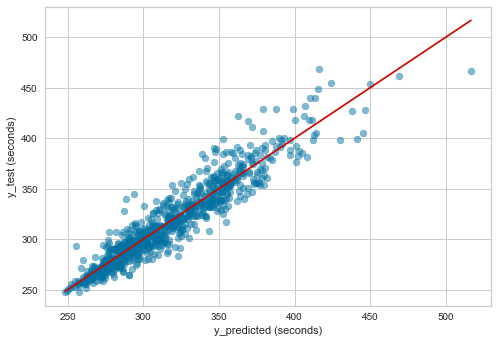

In [43]:
plt.scatter(y_pred,y_test,alpha=0.5);
plt.ylabel('y_test (seconds)');
plt.xlabel('y_predicted (seconds)');

plt.plot([max(y_pred),min(y_pred)],[max(y_pred),min(y_pred)],color='r')
#plt.plot([240,470],[240,470],color='r')

#plt.savefig('test_vs_pred.png');


In [44]:
print('Using all data (9th, 10th & 11th grades) to predict 12th grade PR')
print('Train R^2: ',lr.score(X_train, y_train))
print('Train RMSE:', 
      sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print('Test R^2: ', lr.score(X_test, y_test))
print('Test RMSE:', 
        sqrt(mean_squared_error(y_test, lr.predict(X_test))))

data = y_test-lr.predict(X_test)
print('Skew:',skew(data))
print("mean : ", np.mean(data))
print("var  : ", np.var(data))
print("skew : ",skew(data))
print("kurt : ",kurtosis(data))

Using all data (9th, 10th & 11th grades) to predict 12th grade PR
Train R^2:  0.898635453575
Train RMSE: 13.68117169385355
Test R^2:  0.89277293232
Test RMSE: 13.550339934346301
Skew: 0.661835701754542
mean :  -0.14719738480684022
var  :  183.5900452662461
skew :  0.661835701754542
kurt :  2.154821285674302


Text(0.5,0,'y_predicted - y')

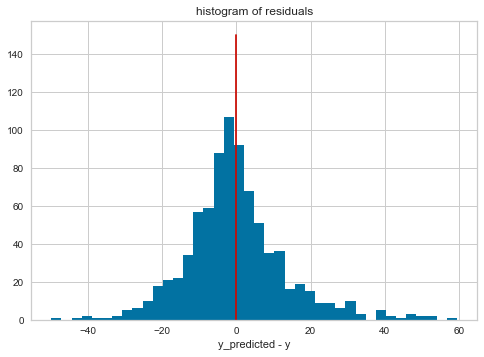

In [113]:
data = y_test-lr.predict(X_test)

plt.hist(data,40)
plt.plot([0,0],[0,150],color='r')
plt.title('histogram of residuals')
plt.xlabel('y_predicted - y')

In [27]:
#remove 9th grade PR data - how good does it do now
X1_train = X_train.drop(['PR9'],axis=1)
X1_test = X_test.drop(['PR9'],axis=1)

lr.fit(X1_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
print('Using only 10th & 11th to predict 12th grade PR')
print('Train R^2: ',lr.score(X1_train, y_train))
print('Train RMSE:', 
      sqrt(mean_squared_error(y_train, lr.predict(X1_train))))
print('Test R^2: ', lr.score(X1_test, y_test))
print('Test RMSE:', 
      sqrt(mean_squared_error(y_test, lr.predict(X1_test))))

Using only 10th & 11th to predict 12th grade PR
Train R^2:  0.8982493793
Train RMSE: 13.707201152648512
Test R^2:  0.893116978601
Test RMSE: 13.528583815607185


In [29]:
#remove 9th grade PR data - how good does it do now
# only select boys
athlete_data_boy = athlete_data[athlete_data.sex == 'boy'].copy()

X1,y1 = get_Xy(athlete_data_boy,100)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4,random_state=42)

X1_train.drop(['PR9'],axis=1)
              
lr = LinearRegression()

lr.fit(X1_train,y1_train)

print('Using only 10th & 11th to predict 12th grade PR for boys')
print('Train R^2: ',lr.score(X1_train, y1_train))
print('Train RSSE:', 
      sqrt(mean_squared_error(y1_train, lr.predict(X1_train))))
print('Test R^2: ', lr.score(X1_test, y1_test))
print('Test RSSE:', 
      sqrt(mean_squared_error(y1_test, lr.predict(X1_test))))

Using only 10th & 11th to predict 12th grade PR for boys
Train R^2:  0.820824539286
Train RSSE: 11.236528449902151
Test R^2:  0.8187794464
Test RSSE: 11.147936440988937


In [30]:
#remove 10th and 11th grade PR data - how good does it do now
X2_train = X_train.drop(['PR10','PR11'],axis=1)
X2_test = X_test.drop(['PR10','PR11'],axis=1)

lr.fit(X2_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
print('Using only 9th grade to predict 12th grade PR')
print('Train R^2: ',lr.score(X2_train, y_train))
print('Train SSE:', 
      mean_squared_error(y_train, lr.predict(X2_train)))
print('Test R^2: ', lr.score(X2_test, y_test))
print('Test SSE:', 
      mean_squared_error(y_test, lr.predict(X2_test)))

Using only 9th grade to predict 12th grade PR
Train R^2:  0.786589037623
Train SSE: 394.073498265
Test R^2:  0.786767208795
Test SSE: 365.132039573


In [32]:
# add a PR11**2 and PR10**2 term to linear regression
X3_train = X_train.copy()
X3_train['PR11squared'] = X_train['PR11']**2
X3_train['PR10squared'] = X_train['PR10']**2

X3_test = X_test.copy()
X3_test['PR11squared'] = X_test['PR11']**2
X3_test['PR10squared'] = X_test['PR10']**2

# Create an empty model
lr = LinearRegression()

lr.fit(X3_train,y_train)

print('Using squared terms as well to predict 12th grade PR')
print('Train R^2: ',lr.score(X3_train, y_train))
print('Train RMSE:', 
      sqrt(mean_squared_error(y_train, lr.predict(X3_train))))
print('Test R^2: ', lr.score(X3_test, y_test))
print('Test RMSE:', 
      sqrt(mean_squared_error(y_test, lr.predict(X3_test))))

Using squared terms as well to predict 12th grade PR
Train R^2:  0.899519286798
Train RMSE: 13.621395626302093
Test R^2:  0.894574407412
Test RMSE: 13.436031118579585


In [33]:
# add a PR11**2 and PR10**2 term to linear regression
X4_train = X_train.copy()
X4_train['PR11squared'] = X_train['PR11']**2
X4_train['PR10squared'] = X_train['PR10']**2
#X4_train['PR11_o_PR10'] = X_train['PR11']/X_train['PR10']
#X4_train['PR10_o_PR9'] = X_train['PR10']/X_train['PR9']


X4_test = X_test.copy()
X4_test['PR11squared'] = X_test['PR11']**2
X4_test['PR10squared'] = X_test['PR10']**2
#X4_test['PR11_o_PR10'] = X_test['PR11']/X_test['PR10']
#X4_test['PR10_o_PR9'] = X_test['PR11']/X_test['PR9']

# Create an empty model
lr = LinearRegression()

lr.fit(X4_train,y_train)

print('Using squared terms as well to predict 12th grade PR')
print('Train R^2: ',lr.score(X4_train, y_train))
print('Train RMSE:', 
      sqrt(mean_squared_error(y_train, lr.predict(X4_train))))
print('Test R^2: ', lr.score(X4_test, y_test))
print('Test RMSE:', 
      sqrt(mean_squared_error(y_test, lr.predict(X4_test))))

data = y_test-lr.predict(X4_test)
print('Skew:',skew(data))
print("mean : ", np.mean(data))
print("var  : ", np.var(data))
print("skew : ",skew(data))
print("kurt : ",kurtosis(data))

Using squared terms as well to predict 12th grade PR
Train R^2:  0.899519286798
Train RMSE: 13.621395626302093
Test R^2:  0.894574407412
Test RMSE: 13.436031118579585
Skew: 0.7228464680218013
mean :  -0.2243058849067421
var  :  180.47661908943542
skew :  0.7228464680218013
kurt :  2.0783709466635685


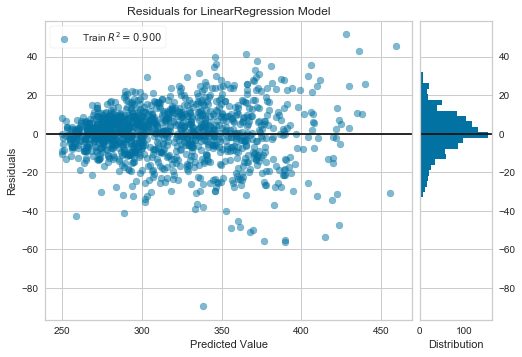

In [34]:
import yellowbrick
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model = lr)

visualizer.fit(X3_train, y_train)  # Fit the training data to the model
visualizer.poof()

Now do it with statsmodels

In [ ]:
X = pd.DataFrame()

# create one-hot columns for District
X = pd.get_dummies(athlete_data[['District']])

X = pd.concat([X, athlete_data[['PR9','PR10','PR11','Nsex','Grad_Yr']]], axis=1, sort=False)

y = athlete_data['PR12']
#y = pd.DataFrame(y.values.reshape((len(y),1)))

In [ ]:
X.shape,y.shape

In [ ]:
sm_data = pd.DataFrame()

# create one-hot columns for District
sm_data = pd.get_dummies(athlete_data[['District']])

sm_data = pd.concat([X, athlete_data[['PR9','PR10','PR11','PR12','Nsex','Grad_Yr']]], axis=1, sort=False)


In [ ]:
y_train_sm, X_train_sm = patsy.dmatrices('PR12 ~ PR9 + PR10 + PR11 + Nsex + Grad_Yr',data = sm_data, return_type='dataframe')

model = sm.OLS(y_train_sm,X_train_sm)
fit = model.fit()
print(fit.summary())

Explore the effect of sample size on the results.

In [166]:
# Set District to filter for only one district, Dist=100 is all districts
Dist = 100
filtered_X, filtered_y = get_Xy(athlete_data,Dist)

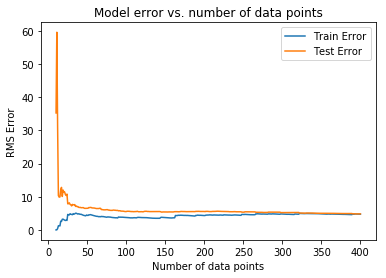

In [167]:
#divide into train and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_X, filtered_y, test_size=0.4,
                                                    random_state=42,stratify=filtered_X['Nsex'])

# Create an empty model
output_data = pd.DataFrame()

max_sample_size = min(401,len(X_train))

for sample_size in range(10,max_sample_size,1):
    X2_train = X_train.sample(n=sample_size,random_state=1)
    y2_train = y_train.sample(n=sample_size,random_state=1)
    #X2_test = X_test.sample(n=sample_size,random_state=1)
    #y2_test = y_test.sample(n=sample_size,random_state=1)
    
    lr = LinearRegression()
    lr.fit(X2_train, y2_train)
    y2_predict = lr.predict(X_test)

    test_score  = lr.score(X_test,y_test)
    train_score = lr.score(X2_train,y2_train)
    train_error = mean_squared_error(y2_train, lr.predict(X2_train))
    test_error  = mean_squared_error(y_test,  lr.predict(X_test))
    #test_error  = mean_squared_error(y2_test,  lr.predict(X2_test))

    #print(sample_size,train_error,test_error)

    output_data = output_data.append([[sample_size,test_score,train_score,train_error,test_error]])
    
    #print('Train R^2: ', train_score)
    #print('Train SSE:', train_error)
    #print('Test R^2: ', test_score)
    #print('Test SSE:', test_error)
    
plt.plot(output_data[0],output_data[3],label='Train Error')
plt.plot(output_data[0],output_data[4],label='Test Error')
plt.legend()
plt.title('Model error vs. number of data points');
plt.xlabel('Number of data points');
plt.ylabel('RMS Error');

In [168]:
print('boys in train set: ',X_train[X_train.Nsex == 1]['Nsex'].count())
print('girls in train set:',X_train[X_train.Nsex == 0]['Nsex'].count())
print('boys in test set:  ',X_test[X_test.Nsex == 1]['Nsex'].count())
print('girls in test set: ',X_test[X_test.Nsex == 0]['Nsex'].count())

boys in train set:  264
girls in train set: 226
boys in test set:   176
girls in test set:  152


## LASSO shows feature importance <a name='LASSO' />

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                        random_state=42,stratify=X['Nsex'])

lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

0.88391840996472482

In [86]:
#lr_lasso.get_params()['lassocv'].alpha_
lr_lasso.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [87]:
X_train.columns

Index(['District_District 1', 'District_District 2', 'District_District 3',
       'District_District 4', 'District_District 5', 'District_District 6',
       'PR9', 'PR10', 'PR11', 'Nsex', 'Grad_Yr'],
      dtype='object')

In [88]:
print(X_train.shape)
print(y_train.shape,lr_lasso.predict(X_train).shape)
X_train.head()

(490, 11)
(490,) (490,)


,District_District 1,District_District 2,District_District 3,District_District 4,District_District 5,District_District 6,PR9,PR10,PR11,Nsex,Grad_Yr
73,1,0,0,0,0,0,61.25,59.54,59.31,0,2012
21,1,0,0,0,0,0,54.11,51.64,49.88,1,2011
141,0,0,1,0,0,0,66.26,63.91,66.57,0,2013
234,0,0,0,1,0,0,71.64,68.14,66.12,0,2016
130,0,0,0,0,1,0,62.39,61.11,60.75,0,2013


In [89]:
print('Train R^2: ',lr_lasso.score(X_train, y_train))
print('Train RMSE:', sqrt(mean_squared_error(y_train,lr_lasso.predict(X_train))))
print('Test R^2: ', lr_lasso.score(X_test, y_test))
print('Test RMSE:',  sqrt(mean_squared_error(y_test, lr_lasso.predict(X_test))))

Train R^2:  0.883918409965
Train RMSE: 2.1578139675088863
Test R^2:  0.883683886525
Test RMSE: 2.2171318272088874


In [90]:
alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y_test, lr_lasso.predict(X_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

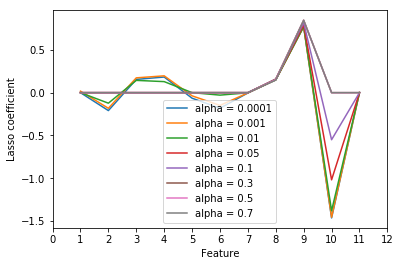

In [91]:
num_features = X.shape[1]

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    if test:
        plt.plot(range(1,num_features+1),coef,label=f"alpha = {alpha}")
plt.legend()
plt.xticks(np.linspace(0,num_features+1, num=num_features+2));
plt.xlabel('Feature')
plt.ylabel('Lasso coefficient');

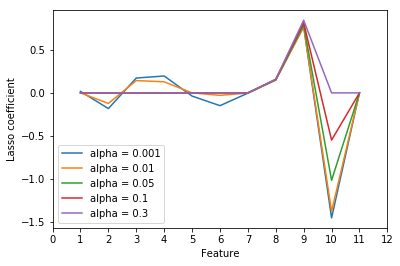

In [94]:
num_features = X.shape[1]

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    #test = (alpha == 0.7)
    test = (alpha >= 0.001) and (alpha <= .3)
    if test:
        plt.plot(range(1,num_features+1),coef,label=f"alpha = {alpha}")
plt.legend()
plt.xticks(np.linspace(0,num_features+1, num=num_features+2));
plt.xlabel('Feature')
plt.ylabel('Lasso coefficient');

In [95]:
X_train.columns

Index(['District_District 1', 'District_District 2', 'District_District 3',
       'District_District 4', 'District_District 5', 'District_District 6',
       'PR9', 'PR10', 'PR11', 'Nsex', 'Grad_Yr'],
      dtype='object')

In [96]:
pd.DataFrame(lasso_results)

,0,1,2,3
0,0.0001,0.886624,"[1.7313692991980235e-07, -0.20962473464032638,...",2.184937
1,0.0010,0.886623,"[0.017453675588172925, -0.18286522668338284, 0...",2.184752
2,0.0100,0.886517,"[0.0, -0.12311329412319823, 0.1434205590303395...",2.184077
3,0.0500,0.885562,"[0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.1534...",2.195529
4,0.1000,0.883918,"[0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.1581...",2.217132
5,0.3000,0.880540,"[0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.15906...",2.258098
6,0.5000,0.880410,"[0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.15284...",2.261331
7,0.7000,0.880215,"[0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.14661...",2.265190


In [58]:
lasso_results[5][2]

[0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.04783524779205888,
 0.11477295015994243,
 0.8238894282851263,
 -3.4847974626634044,
 -0.16681598616548685]

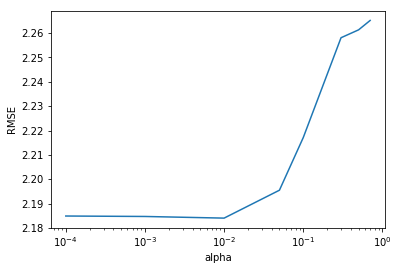

In [97]:
xx = [row[0] for row in lasso_results]
yy = [row[3] for row in lasso_results]
plt.semilogx(xx,yy);
plt.xlabel('alpha')
plt.ylabel('RMSE');

## Modeling District as a mixed effect <a name='MixedEffect' />

Random effect - District    
Fixed effect - PRs from each year, grad year   

We expect to see some clustering due to the random effect variable.

In [182]:
sm_data = athlete_data[['District','PR9','PR10','PR11','PR12','Nsex','Grad_Yr']]

y_train_sm, X_train_sm = patsy.dmatrices('PR12 ~ PR9 + PR10 + PR11 + Nsex + Grad_Yr',
                                         data = sm_data, return_type='dataframe')

In [183]:
print(sm_data.shape)
sm_data.head()

(2056, 7)


,District,PR9,PR10,PR11,PR12,Nsex,Grad_Yr
0,District 3,271.44,264.50,255.28,252.97,1,2011
1,District 3,276.00,265.58,268.16,265.20,1,2011
2,District 5,293.90,278.42,281.35,275.15,1,2011
3,District 1,283.22,264.46,261.56,257.71,1,2012
4,District 3,302.14,284.32,284.20,289.45,1,2011


In [100]:
print(y_train_sm.shape,X_train_sm.shape)

(818, 1) (818, 6)


In [101]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
#data_train = pd.concat([y_train,X_train],axis=1,sort=False)
#data_test  = pd.concat([y_test,X_test],axis=1,sort=False)

In [102]:
#md = smf.mixedlm("12_PR ~ 9_PR + 10_PR + 11_PR + sex + Grad_Yr",
#                data = athlete_data,
#                groups = athlete_data["District"])

md = smf.mixedlm('PR12 ~ PR9 + PR10 + PR11 + Nsex + Grad_Yr',
                data = sm_data,
                groups = sm_data['District'])
mdf = md.fit()
print(mdf.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PR12      
No. Observations: 818     Method:             REML      
No. Groups:       6       Scale:              4.6238    
Min. group size:  56      Likelihood:         -1809.4447
Max. group size:  227     Converged:          No        
Mean group size:  136.3                                 
--------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------
Intercept  -6.876   58.695 -0.117 0.907 -121.916 108.163
PR9         0.001    0.027  0.033 0.973   -0.051   0.053
PR10        0.225    0.039  5.793 0.000    0.149   0.301
PR11        0.698    0.034 20.356 0.000    0.631   0.765
Nsex       -1.534    0.235 -6.534 0.000   -1.994  -1.074
Grad_Yr     0.006    0.029  0.200 0.842   -0.051   0.063
Group Var   4.624                                       



/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [103]:
y_sm = sm_data['PR12']
#X_sm = sm_data = athlete_data[['District','PR9','PR10','PR11','Nsex','Grad_Yr']]
#y_sm_predict = mdf.predict(X_sm)


In [104]:
y_sm_predict = mdf.fittedvalues
RMSE = sqrt(((y_sm-y_sm_predict)**2).values.mean())
print(RMSE)

2.1423892550105483


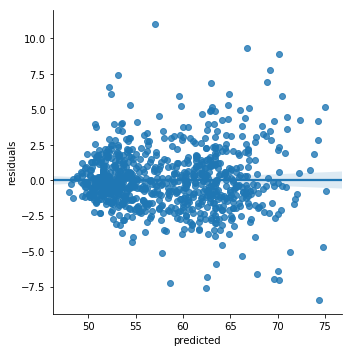

In [105]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["predicted"] = mdf.fittedvalues
performance["residuals"] = mdf.resid.values
#performance["PR12"] = data.age_scaled

sns.lmplot(x = "predicted", y = "residuals", data = performance)

## Algebraic Model <a name='Algebraic' />

How well can you predict 12th grade scores if you use a brute force method.  Assume the ratio in the decrease in times from 10th grade to 11th grade is the same as from 11th grade to 12th grade.  In this way with the competition times in 10th and 11th grade you can predict the time for 12th grade.

In [48]:
athlete_data.head()

,Unnamed: 0,ID,Name,School_ID,School,District,9_PR,10_PR,11_PR,12_PR,Grad_Yr,sex,PR12,PR11,PR10,PR9,Nsex
0,0,290897,Tyler King,298,Coupeville,District 3,271.44,264.50,255.28,252.97,2011,boy,252.97,255.28,264.50,271.44,1
1,1,239023,Bereket Piatt,358,Port Townsend,District 3,276.00,265.58,268.16,265.20,2011,boy,265.20,268.16,265.58,276.00,1
2,2,262221,Ethan Tonnemaker,330,Royal,District 5,293.90,278.42,281.35,275.15,2011,boy,275.15,281.35,278.42,293.90,1
3,3,536508,Hap Emmons,345,King's,District 1,283.22,264.46,261.56,257.71,2012,boy,257.71,261.56,264.46,283.22,1
4,4,330570,Michael Milbank,301,Bellevue Christian,District 3,302.14,284.32,284.20,289.45,2011,boy,289.45,284.20,284.32,302.14,1


In [95]:
print(y_test.iloc[831])

IndexError: single positional indexer is out-of-bounds

In [77]:
print(y_test)

831     274.90
846     280.30
1019    282.81
195     268.96
410     386.70
281     333.77
417     342.32
318     288.02
205     355.82
637     298.15
245     264.55
83      295.33
159     301.20
636     357.04
41      272.13
595     353.70
790     258.35
462     336.30
288     251.85
120     315.94
208     332.13
852     277.98
233     350.33
471     263.76
854     264.31
445     330.44
516     301.74
823     428.70
276     348.16
582     271.16
         ...  
1160    301.09
990     304.24
173     354.90
383     316.00
646     338.29
1053    288.35
212     270.90
1050    262.86
497     267.85
99      332.62
1189    293.16
761     279.66
406     366.18
1145    300.10
352     311.13
710     280.09
228     279.10
333     326.00
220     295.73
553     289.31
540     287.51
377     313.72
942     271.49
578     319.93
1043    302.98
259     301.08
557     307.90
291     353.54
1024    305.18
84      305.30
Name: PR12, Length: 820, dtype: float64


RMSE: 22.146129046355124
12th grade average time: 317.5114024390247


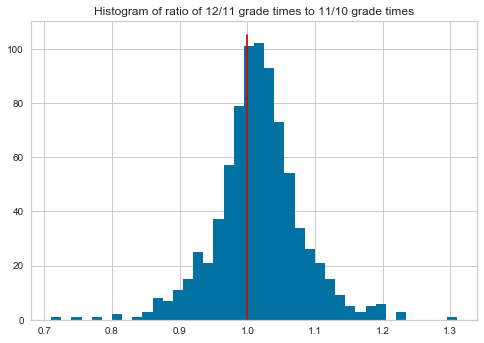

In [108]:
RMSE = 0
average = 0
total = 0
growth = []
growth1 = []
residual = []

max_val = []

df = athlete_data.sample(n=len(y_test))
for index,athlete in df.iterrows():
    g12 = athlete['PR12']
    g11 = athlete['PR11']
    g10 = athlete['PR10']
    g9  = athlete['PR9']
    
    g12_predict = g11 + (g11/g10)*(g11-g10)
    #g12_predict = g11**2/g10

    RMSE += (g12_predict - g12)**2
    average += g12
    total += 1
    growth.append((g12/g11)/(g11/g10))
    residual.append(g12_predict - g12)
    if (g11-g10) != 0: 
        g = (g12-g11)/(g11-g10)
        if g < 5: growth1.append(g)
    max_val.append(g12)
RMSE = sqrt(RMSE/total)
average = average/total

print('RMSE:',RMSE)
print('12th grade average time:',average)

#plt.scatter(max,growth)
#plt.hist(growth1,1000);
plt.hist(growth,40);

plt.title('Histogram of ratio of 12/11 grade times to 11/10 grade times');
#plt.xlim(-10,10)
plt.plot([1,1],[0,105],color='r')
#plt.plot([0,0],[0,130],color='y')

Text(0.5,0,'y_predicted - y')

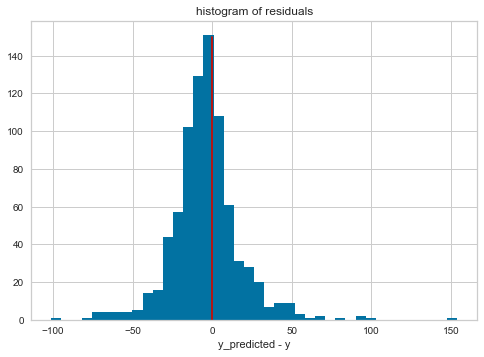

In [112]:
plt.hist(residual,40)
plt.plot([0,0],[0,150],color='r')
plt.title('histogram of residuals')
plt.xlabel('y_predicted - y')